In [ ]:
from google.colab import userdata
import json

# Get the Kaggle credentials from Colab's userdata
username = userdata.get("KAGGLE_USER")
key = userdata.get("KAGGLE_KEY")

# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c io-t-sleep-stage-classification-version-2
!unzip /content/io-t-sleep-stage-classification-version-2.zip
!rm -rf /content/io-t-sleep-stage-classification-version-2

Streaming output truncated to the last 5000 lines.
  inflating: test_segment/test_segment/test003/test003_00692.csv  
  inflating: test_segment/test_segment/test003/test003_00693.csv  
  inflating: test_segment/test_segment/test003/test003_00694.csv  
  inflating: test_segment/test_segment/test003/test003_00695.csv  
  inflating: test_segment/test_segment/test003/test003_00696.csv  
  inflating: test_segment/test_segment/test003/test003_00697.csv  
  inflating: test_segment/test_segment/test003/test003_00698.csv  
  inflating: test_segment/test_segment/test003/test003_00699.csv  
  inflating: test_segment/test_segment/test003/test003_00700.csv  
  inflating: test_segment/test_segment/test004/test004_00000.csv  
  inflating: test_segment/test_segment/test004/test004_00001.csv  
  inflating: test_segment/test_segment/test004/test004_00002.csv  
  inflating: test_segment/test_segment/test004/test004_00003.csv  
  inflating: test_segment/test_segment/test004/test004_00004.csv  
  inflating

After run this cell, restart session and run the next cell further.

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pywt

from tqdm import tqdm
import random
import glob
import os

## Preprocessing

In [ ]:
label_map = {'W': 0, 'N': 1, 'R': 2}

def split_chunk(file_path):
    df = pd.read_csv(file_path)
    X, y = df.drop(columns='Sleep_Stage'), df['Sleep_Stage']

    start, end = 0, 480
    chunks, y_per_chunk = [], []
    for i in range(df.shape[0]//480):
        chunks.append(X[start:end].to_numpy())

        chunk_label = y.loc[start:end].map(label_map).mode()
        y_per_chunk.append(chunk_label)

        start += 480
        end += 480

    return np.stack(chunks, axis=0), np.array(y_per_chunk)

def signal_prep(files):
    X_prep, y_prep = [], []
    for i, file in enumerate(tqdm(files)):
        X_cat, y_cat = split_chunk(file)

        if i == 0:
            X_prep = X_cat
            y_prep = y_cat
        else:
            X_prep = np.concatenate([X_prep, X_cat], axis=0)
            y_prep = np.append(y_prep, y_cat)

    return X_prep, y_prep

In [ ]:
train_path = '/content/train/train/'
train_files = np.sort(glob.glob(os.path.join(train_path, "*.csv")))

X_prep, y_prep = signal_prep(train_files)
print(f"\nDataset: {X_prep.shape}, {y_prep.shape}")

100%|██████████| 83/83 [02:54<00:00,  2.10s/it]


Dataset: (66473, 480, 8), (66473,)


In [ ]:
sleep_map = {0: 'Wake', 1: 'Non-REM', 2: 'REM'}

pd.crosstab(pd.Series(y_prep).map(sleep_map), columns='N').sort_values('N')

col_0,N
row_0,
REM,6996
Wake,16027
Non-REM,43450


## EDA

In [ ]:
sample_index = random.randint(0, len(y_prep) - 1)
print(f"Randomly selected sample index: {sample_index}")
activity_label = int(y_prep[sample_index])

# Extract signal for the sample
acc_x = X_prep[sample_index, :, 1]
acc_y = X_prep[sample_index, :, 2]
acc_z = X_prep[sample_index, :, 3]

activity_name = sleep_map[activity_label]

Randomly selected sample index: 46295


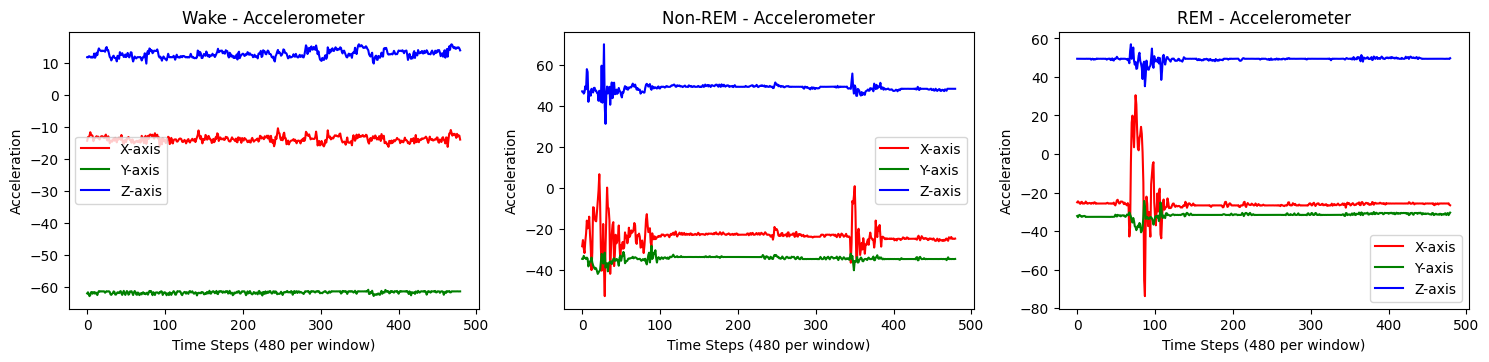

In [ ]:
# Select one sample for each activity
activity_samples = {activity: np.where(y_prep == activity)[0][10]
                    for activity in sleep_map.keys()}

# Visualize accelerometer and gyroscope signals for each activity
plt.figure(figsize=(15, 10))  # Adjust figure size for better readability

for activity, index in activity_samples.items():
    # Get accelerometer signals
    acc_x = X_prep[index, :, 1]
    acc_y = X_prep[index, :, 2]
    acc_z = X_prep[index, :, 3]

    # Subplot for accelerometer
    plt.subplot(len(sleep_map), 3, activity+1)
    plt.plot(acc_x, label='X-axis', color='r')
    plt.plot(acc_y, label='Y-axis', color='g')
    plt.plot(acc_z, label='Z-axis', color='b')
    plt.title(f"{sleep_map[activity]} - Accelerometer")
    plt.xlabel("Time Steps (480 per window)")
    plt.ylabel("Acceleration")
    plt.legend()

plt.tight_layout()
plt.show()

**Fast Fourier Transform**

In [ ]:
sampling_rate = 16

def apply_fft(signal):
    n = len(signal)
    fft_signal = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(len(fft_signal), 1/sampling_rate)  # Frequency bins in Hz
    fft_mag = np.abs(fft_signal)  # Magnitude of FFT (absolute value)

    return fft_freq, fft_mag

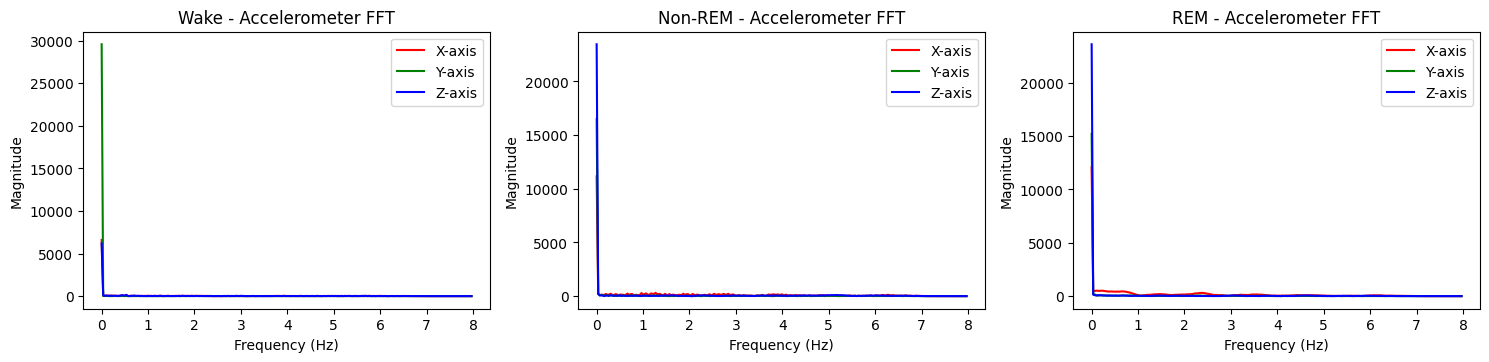

In [ ]:
plt.figure(figsize=(15, 10))
for activity, index in activity_samples.items():
    # Get accelerometer signals
    acc_x = X_prep[index, :, 1]
    acc_y = X_prep[index, :, 2]
    acc_z = X_prep[index, :, 3]

    # Apply FFT to accelerometer signals
    fft_acc_x_freq, fft_acc_x_mag = apply_fft(acc_x)
    fft_acc_y_freq, fft_acc_y_mag = apply_fft(acc_y)
    fft_acc_z_freq, fft_acc_z_mag = apply_fft(acc_z)

    # Subplot for accelerometer FFT
    plt.subplot(len(sleep_map), 3, activity + 1)
    plt.plot(fft_acc_x_freq[:len(fft_acc_x_freq)//2], fft_acc_x_mag[:len(fft_acc_x_mag)//2], label='X-axis', color='r')
    plt.plot(fft_acc_y_freq[:len(fft_acc_y_freq)//2], fft_acc_y_mag[:len(fft_acc_y_mag)//2], label='Y-axis', color='g')
    plt.plot(fft_acc_z_freq[:len(fft_acc_z_freq)//2], fft_acc_z_mag[:len(fft_acc_z_mag)//2], label='Z-axis', color='b')
    plt.title(f"{sleep_map[activity]} - Accelerometer FFT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()

plt.tight_layout()
plt.show()

Blood Volume Pulse

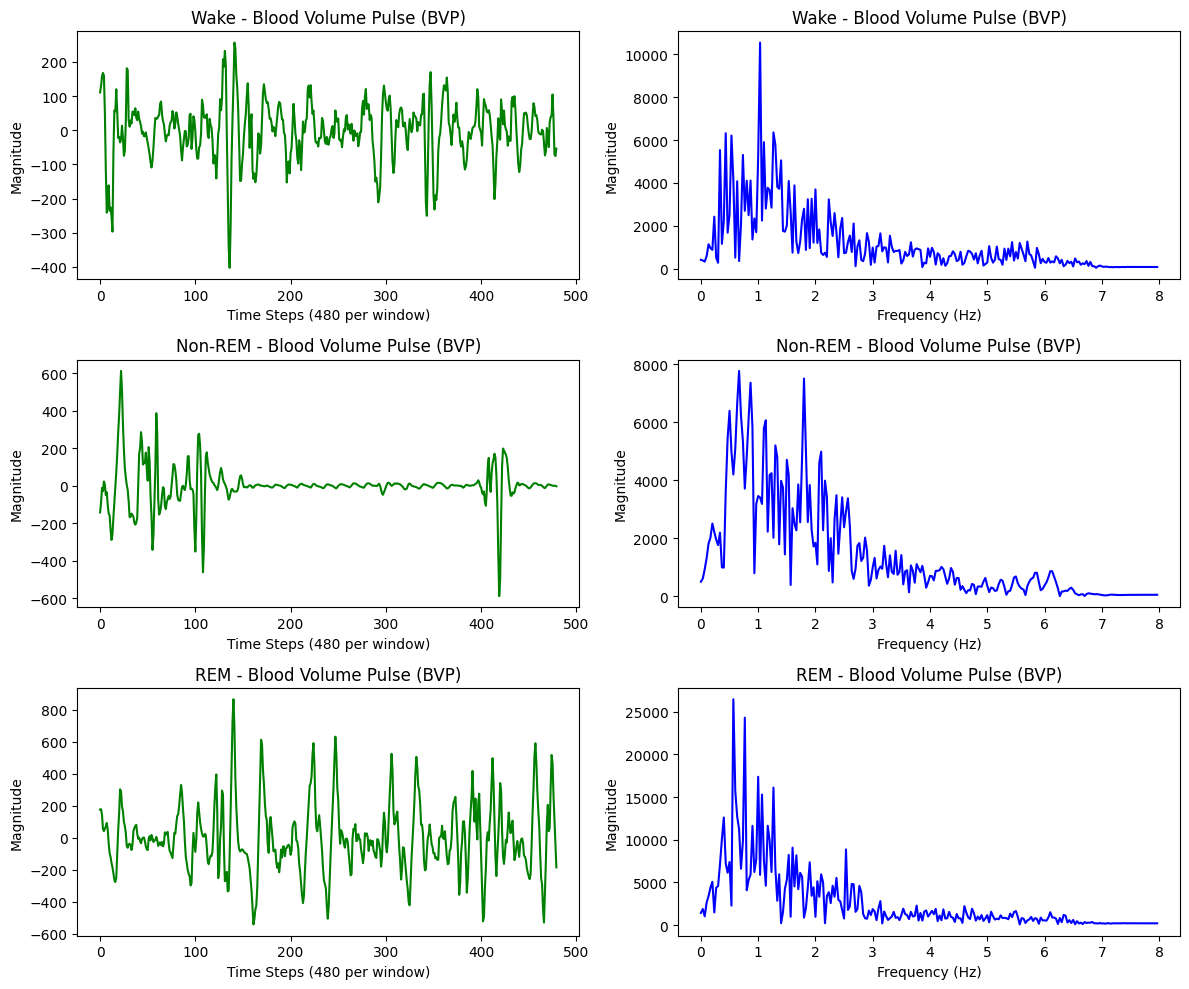

In [ ]:
plt.figure(figsize=(12, 10))
fft_mag_temp = []
for activity, index in activity_samples.items():
    # Get accelerometer signals
    bvp = X_prep[index, :, 0]

    fft_bvp_freq, fft_bvp_mag = apply_fft(bvp)
    fft_mag_temp.append(fft_bvp_mag)
    # fft_bvp_mag = scaler.fit_transform(fft_bvp_mag.reshape(-1, 1)).flatten()

    plt.subplot(len(sleep_map), 2, (activity*2) + 1)
    plt.plot(bvp, color='g')
    plt.title(f"{sleep_map[activity]} - Blood Volume Pulse (BVP)")
    plt.xlabel("Time Steps (480 per window)")
    plt.ylabel("Magnitude")

    # Subplot for accelerometer FFT
    plt.subplot(len(sleep_map), 2, (activity*2) + 2)
    plt.plot(fft_bvp_freq[:len(fft_bvp_freq)//2], fft_bvp_mag[:len(fft_bvp_mag)//2], color='b')
    plt.title(f"{sleep_map[activity]} - Blood Volume Pulse (BVP)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()

### Filtering

In [ ]:
from scipy.signal import butter, filtfilt

# highpass Filter
def butter_highpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high')
    return b, a


# Band-Pass Filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

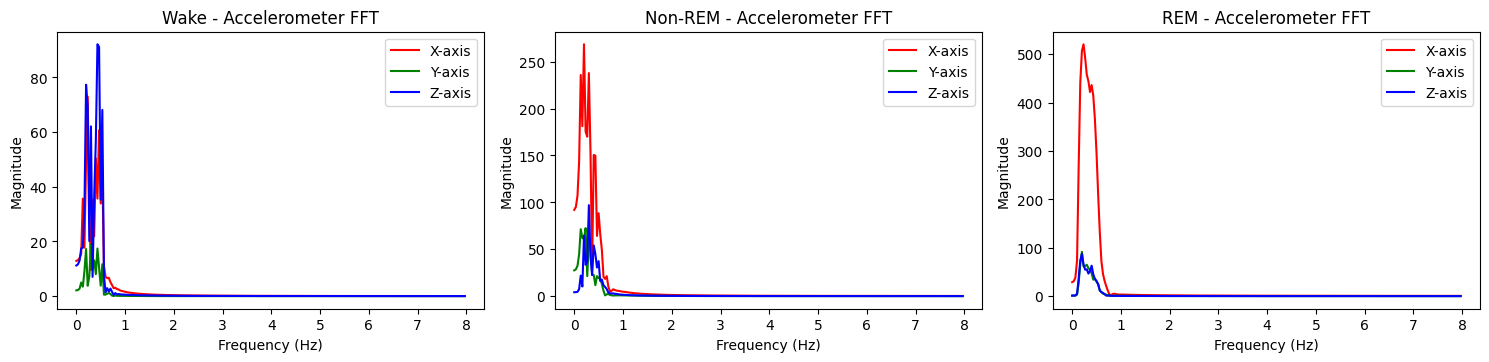

In [ ]:
fs = 480

plt.figure(figsize=(15, 10))
for activity, index in activity_samples.items():
    # Get accelerometer signals
    acc_x = X_prep[index, :, 1]
    acc_y = X_prep[index, :, 2]
    acc_z = X_prep[index, :, 3]

    b, a = butter_bandpass(4, 16, fs, order=4)
    acc_x_filtered = filtfilt(b, a, acc_x)
    acc_y_filtered = filtfilt(b, a, acc_y)
    acc_z_filtered = filtfilt(b, a, acc_z)

    # Apply FFT to accelerometer signals
    fft_acc_x_freq, fft_acc_x_mag = apply_fft(acc_x_filtered)
    fft_acc_y_freq, fft_acc_y_mag = apply_fft(acc_y_filtered)
    fft_acc_z_freq, fft_acc_z_mag = apply_fft(acc_z_filtered)

    # Subplot for accelerometer FFT
    plt.subplot(len(sleep_map), 3, activity + 1)
    plt.plot(fft_acc_x_freq[:len(fft_acc_x_freq)//2], fft_acc_x_mag[:len(fft_acc_x_mag)//2], label='X-axis', color='r')
    plt.plot(fft_acc_y_freq[:len(fft_acc_y_freq)//2], fft_acc_y_mag[:len(fft_acc_y_mag)//2], label='Y-axis', color='g')
    plt.plot(fft_acc_z_freq[:len(fft_acc_z_freq)//2], fft_acc_z_mag[:len(fft_acc_z_mag)//2], label='Z-axis', color='b')
    plt.title(f"{sleep_map[activity]} - Accelerometer FFT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()

plt.tight_layout()
plt.show()

### Wavelet Transform

In [ ]:
def wavelet_transform(signal, wavelet='db4', level=4):
    """ Apply wavelet transform and reconstruct signal with selected coefficients """
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Zero-out some detail coefficients to smooth the signal (keep only approximation)
    coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]  # Remove high-frequency details

    # Reconstruct the signal
    reconstructed_signal = pywt.waverec(coeffs, wavelet)

    # Ensure length matches original signal length
    return reconstructed_signal[:len(signal)]

wavelet_signal = wavelet_transform(acc_x)
wavelet_signal.shape

(480,)

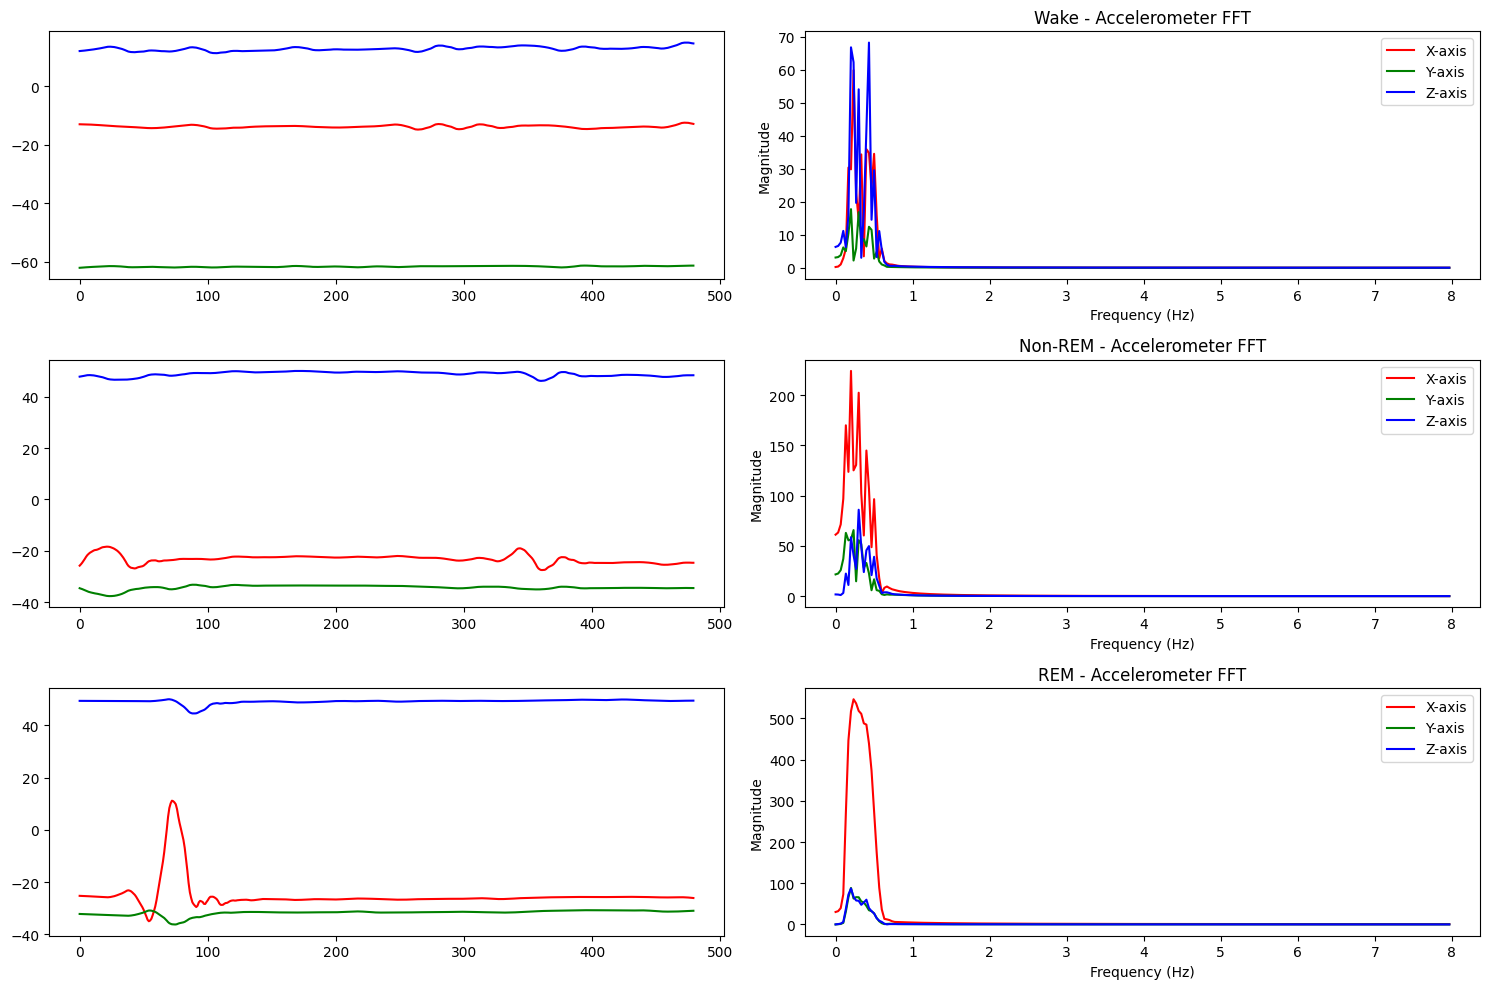

In [ ]:
fs = 480

plt.figure(figsize=(15, 10))
for activity, index in activity_samples.items():
    # Get accelerometer signals
    acc_x = X_prep[index, :, 1]
    acc_y = X_prep[index, :, 2]
    acc_z = X_prep[index, :, 3]

    wavelet_x = wavelet_transform(acc_x)
    wavelet_y = wavelet_transform(acc_y)
    wavelet_z = wavelet_transform(acc_z)

    # high pass
    b, a = butter_bandpass(4, 16, fs, order=4)
    x_filtered = filtfilt(b, a, wavelet_x)
    y_filtered = filtfilt(b, a, wavelet_y)
    z_filtered = filtfilt(b, a, wavelet_z)

    # Apply FFT to accelerometer signals
    fft_acc_x_freq, fft_acc_x_mag = apply_fft(x_filtered)
    fft_acc_y_freq, fft_acc_y_mag = apply_fft(y_filtered)
    fft_acc_z_freq, fft_acc_z_mag = apply_fft(z_filtered)

    # Subplot for wavelet
    plt.subplot(len(sleep_map), 2, (activity*2) + 1)
    plt.plot(wavelet_x, label='X-axis', color='r')
    plt.plot(wavelet_y, label='Y-axis', color='g')
    plt.plot(wavelet_z, label='Z-axis', color='b')

    # Subplot for accelerometer FFT
    plt.subplot(len(sleep_map), 2, (activity*2) + 2)
    plt.plot(fft_acc_x_freq[:len(fft_acc_x_freq)//2], fft_acc_x_mag[:len(fft_acc_x_mag)//2], label='X-axis', color='r')
    plt.plot(fft_acc_y_freq[:len(fft_acc_y_freq)//2], fft_acc_y_mag[:len(fft_acc_y_mag)//2], label='Y-axis', color='g')
    plt.plot(fft_acc_z_freq[:len(fft_acc_z_freq)//2], fft_acc_z_mag[:len(fft_acc_z_mag)//2], label='Z-axis', color='b')
    plt.title(f"{sleep_map[activity]} - Accelerometer FFT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()

plt.tight_layout()
plt.show()

## Classical ML Approach

### Feature Engineering

In [ ]:
temp = pd.read_csv('/content/train/train/train001.csv')
x_col = temp.columns[:-1]
x_col

Index(['BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'IBI'], dtype='object')

In [ ]:
def feature_engineering(X, y=None):
    df = pd.DataFrame(columns=['BVP_mean', 'BVP_std',
                            'ACC_X_mean', 'ACC_X_std',
                            'ACC_Y_mean', 'ACC_Y_std',
                            'ACC_Z_mean', 'ACC_Z_std'])

    for batch in tqdm(X):
        bvp_mean = batch[:, 0].mean()
        bvp_std = batch[:, 0].std()

        acc_x_mean = batch[:, 1].mean()
        axx_y_mean = batch[:, 2].mean()
        acc_z_mean = batch[:, 3].mean()

        acc_x_std = batch[:, 1].std()
        axx_y_std = batch[:, 2].std()
        acc_z_std = batch[:, 3].std()

        cat_temp = pd.DataFrame([[bvp_mean, bvp_std,
                                    acc_x_mean, acc_x_std,
                                    axx_y_mean, axx_y_std,
                                    acc_z_mean, acc_z_std]],
                                columns=df.columns)
        df = pd.concat([df, cat_temp])

    if y != None:
        df['Sleep_Stage'] = y

    return df.reset_index(drop=True)


df = feature_engineering(X_prep, y_prep)
print(df.shape)
df.head()


  3%|▎         | 2201/66473 [00:02<01:19, 804.39it/s]


KeyboardInterrupt: 

{0: 'W', 1: 'N', 2: 'R'}


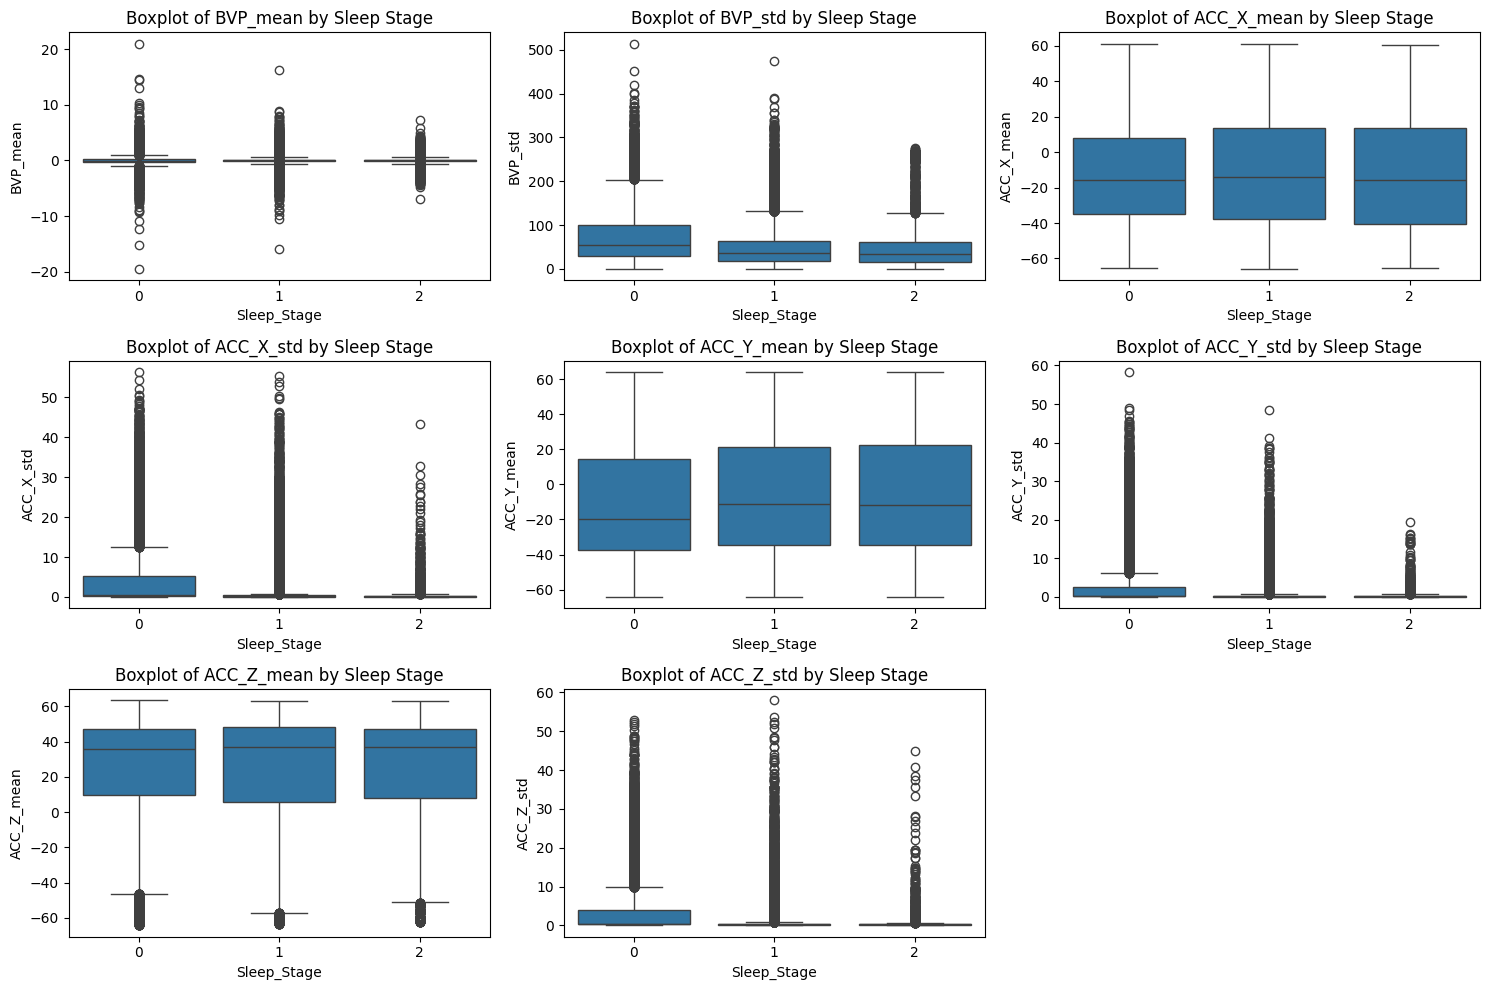

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns[:-1]):  # Iterate through all columns except 'Sleep_Stage'
  plt.subplot(3, 3, i + 1)
  sns.boxplot(x='Sleep_Stage', y=col, data=df)
  plt.title(f'Boxplot of {col} by Sleep Stage')
plt.tight_layout()
plt.show()


### Model Selection

In [ ]:
!pip install pycaret[full]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from pycaret.classification import *

In [ ]:
df_prep = df[ df['Sleep_Stage'] == 2 ]
temp_1 = df[ df['Sleep_Stage'] == 0 ]
temp_2 = df[ df['Sleep_Stage'] == 1 ]

df_prep = pd.concat([temp_1.sample(len(df_prep)), temp_2.sample(len(df_prep)), df_prep]).reset_index(drop=True)
pd.crosstab(df_prep.iloc[:, -1], columns='N')

col_0,N
Sleep_Stage,
0,6996
1,6996
2,6996


In [ ]:
classification_setup = setup(data=df_prep, target='Sleep_Stage',
                             train_size=0.8, session_id=42, use_gpu=False)

best_model = compare_models(sort='F1', include=['knn', 'dt', 'rf', 'et', 'gbc', 'xgboost', 'lightgbm'])

# Train the best model (optional, you can choose another model from compare_models)
best_model = create_model(best_model)

,Description,Value
0,Session id,42
1,Target,Sleep_Stage
2,Target type,Multiclass
3,Original data shape,"(20988, 9)"
4,Transformed data shape,"(20988, 9)"
5,Transformed train set shape,"(16790, 9)"
6,Transformed test set shape,"(4198, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7950,0.9180,0.7950,0.7960,0.7951,0.6925,0.6928,2.1040
rf,Random Forest Classifier,0.7578,0.8948,0.7578,0.7589,0.7581,0.6367,0.6370,5.6430
xgboost,Extreme Gradient Boosting,0.7501,0.8888,0.7501,0.7490,0.7492,0.6252,0.6255,1.1980
knn,K Neighbors Classifier,0.7292,0.8705,0.7292,0.7275,0.7276,0.5939,0.5945,1.1230
lightgbm,Light Gradient Boosting Machine,0.7262,0.8758,0.7262,0.7249,0.7250,0.5893,0.5897,6.1040
dt,Decision Tree Classifier,0.6700,0.7525,0.6700,0.6693,0.6694,0.5051,0.5053,0.2690
gbc,Gradient Boosting Classifier,0.6080,0.0000,0.6080,0.6079,0.6071,0.4120,0.4126,18.9400


Processing:   0%|          | 0/33 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7808,0.9151,0.7808,0.7824,0.7812,0.6712,0.6716
1,0.7832,0.9115,0.7832,0.7843,0.7835,0.6748,0.6750
2,0.7969,0.9179,0.7969,0.7973,0.7969,0.6954,0.6956
3,0.8023,0.9235,0.8023,0.8029,0.8021,0.7034,0.7038
4,0.8076,0.9219,0.8076,0.8078,0.8074,0.7114,0.7117
5,0.7886,0.9157,0.7886,0.7893,0.7888,0.6828,0.6829
6,0.7719,0.9088,0.7719,0.7731,0.7724,0.6578,0.6579
7,0.7898,0.9157,0.7898,0.7917,0.7900,0.6846,0.6854
8,0.8291,0.9344,0.8291,0.8295,0.8289,0.7436,0.7440


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# tuned_model = tune_model(best_model, search_library='optuna')
final_model = finalize_model(best_model)
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
train_pred = predict_model(final_model, df)['prediction_label']

print(classification_report(df['Sleep_Stage'], train_pred))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8394,0.9613,0.8394,0.8692,0.8437,0.7108,0.7258


              precision    recall  f1-score   support

           0       0.68      0.89      0.77     16027
           1       0.96      0.80      0.87     43450
           2       0.73      1.00      0.85      6996

    accuracy                           0.84     66473
   macro avg       0.79      0.89      0.83     66473
weighted avg       0.87      0.84      0.84     66473



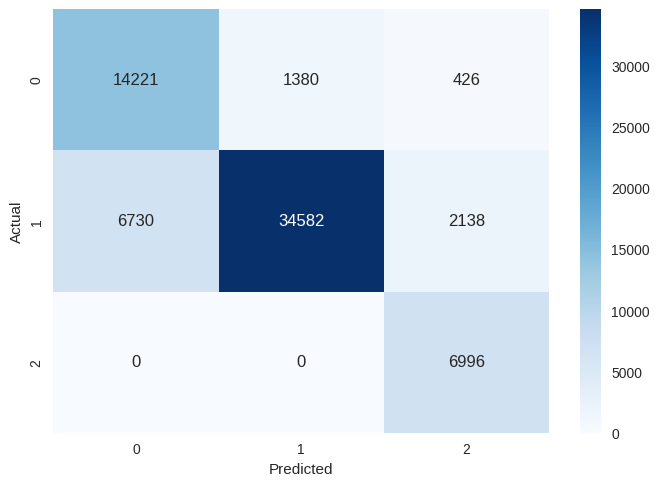

In [ ]:
sns.heatmap(confusion_matrix(df['Sleep_Stage'], train_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()